# TAIL-RISK FUND: OPTIONS

author: [@sparshsah](https://github.com/sparshsah)

ref: https://github.com/sparshsah/foggy-demo/blob/main/demo/finance/tail-risk-fund.md

In [1]:
from __future__ import annotations

import pandas as pd

# https://github.com/sparshsah/foggy-statslib
import sys; sys.path.append("../../../foggy-statslib/")
import foggy_statslib.core as fsc
import foggy_statslib.fin as fsf

# EXPLORE

## Setting

You hold one share of S, which is currently trading at 100USD.
(S is SPX, but I don't want the fact that SPX is not tradable and also actually at 3000USD to distract you.)

You believe that it is equally likely to:
1. Fall 20pct over the next 6 months (accompanied by a doubling in ivols), Then stay flat to EOY
2. Stay flat over the next 6 months, Then fall 20pct by EOY
3. Stay flat through EOY

Prevailing option-implied vols are around 16pct,
and for simplicity neglect (a) volatility smirks, (b) the risk-free rate, and (c) tcosts.

Crucially: Unlike most single-name equity options which are American-style, the SPX-like index options we consider are European-style.

In [32]:
sigma: Final[float] = 0.16
r: Final[float] = 0

## Question

Should you
* A: Purchase a 2-quarter put (rolling into another one if the crash fails to materialize by expiry)?
* B: Purchase a 4-quarter put?
* C: Buy "half" of each strategy?

Assuming you fix your strike at 90USD.
Assume also that you finance your puts with borrowing (not selling shares).

In [48]:
init_value_of_one_put_a = fsf.calc_bsf_option_value(
    tau=2/4,
    K=90,
    S_t=100,
    sigma=sigma,
    r=r,
    put=True,
)
init_value_of_one_put_b = fsf.calc_bsf_option_value(
    tau=4/4,
    K=90,
    S_t=100,
    sigma=sigma,
    r=r,
    put=True,
)
print(f"Premium for each Put: A = ${init_value_of_one_put_a:.2f}, B = ${init_value_of_one_put_b:.2f}.")

Premium for each Put: A = $1.02, B = $2.32.


In [64]:
# dollar return under each scenario of different strategies, by quarter

# SCENARIO 1: S falls -20% over the next 6 months, then stays flat to EOY
r1 = pd.DataFrame(
    {
        # the shares
        "principal": {
            0: 0,
            1: 0,
            2: -20,
            3: 0,
            4: 0,
        },
        # the hedges
        # a: a 2-quarter put
        "a": {
            # you gained a put, but owe what you borrowed to buy it, so there's no net pnl
            0: init_value_of_one_put_a - init_value_of_one_put_a,
            1: (
                # your put is now less valuable, as a quarter has passed with no market movements
                fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - init_value_of_one_put_a
            ),
            # you would exercise, earning $10
            2: +10,
            3: 0,
            4: 0,
        },
        # b: a 4-quarter put
        "b": {
            # you gained a put, but owe what you borrowed to buy it, so there's no net pnl
            0: init_value_of_one_put_b - init_value_of_one_put_b,
            1: (
                # your put is now less valuable, as a quarter has passed with no market movements
                fsf.calc_bsf_option_value(
                    tau=3/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - init_value_of_one_put_b
            ),
            2: (
                # your put is now more valuable! thanks to the price crash and associated vol spike.
                fsf.calc_bsf_option_value(
                    tau=2/4,
                    K=90,
                    S_t=80,  # down from 100
                    sigma=2*sigma,  # doubled
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - fsf.calc_bsf_option_value(
                    tau=3/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
            ),
            # now there's no more activity, as you sold your put once you observed the crash
            3: 0,
            4: 0,
        },
    }
)
r1.loc[:, "c"] = r1[["a","b"]].mean(axis="columns")
r1.loc["=>", :] = r1.sum()


# SCENARIO 2: S stays flat over the next 6 months, then drops -20% by EOY
r2 = pd.DataFrame(
    {
        # the shares
        "principal": {
            0: 0,
            1: 0,
            2: 0,
            3: 0,
            4: -20,
        },
        # the hedges
        # a: a 2-quarter put
        "a": {
            # you gained a put, but owe what you borrowed to buy it, so there's no net pnl
            0: init_value_of_one_put_a - init_value_of_one_put_a,
            1: (
                # your put is now less valuable, as a quarter has passed with no market movements
                fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - init_value_of_one_put_a
            ),
            2: (
                # your put is now worthless
                0 - fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # on top of that, you're back to the start: you must now buy a new one (financed with borrowing)
                # Notice: Nothing has changed about the market.
                + (init_value_of_one_put_a - init_value_of_one_put_a)
            ),
            3: (
                # your SECOND put is now again less valuable, as a quarter passes with no market movements
                fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - init_value_of_one_put_a
            ),
            # sweet payoff
            4: +10,
        },
        # b: a 4-quarter put
        "b": {
            # you gained a put, but owe what you borrowed to buy it, so there's no net pnl
            0: init_value_of_one_put_b - init_value_of_one_put_b,
            1: (
                # your put is now less valuable, as a quarter has passed with no market movements
                fsf.calc_bsf_option_value(
                    tau=3/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - init_value_of_one_put_b
            ),
            2: (
                # your put is now EVEN less valuable, as ANOTHER quarter has passed with no market movements
                fsf.calc_bsf_option_value(
                    tau=2/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - fsf.calc_bsf_option_value(
                    tau=3/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
            ),
            # rinse and repeat
            3: (
                fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                - fsf.calc_bsf_option_value(
                    tau=2/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
            ),
            # sweet payoff
            4: +10,
        },
    }
)
r2.loc[:, "c"] = r2[["a","b"]].mean(axis="columns")
r2.loc["=>", :] = r2.sum()

# SCENARIO 3: S stays flat through EOY
r3 = pd.DataFrame(
    {
        # the shares
        "principal": {
            0: 0,
            1: 0,
            2: 0,
            3: 0,
            4: 0,
        },
        # the hedges
        # a: a 2-quarter put
        "a": {
            # you gained a put, but owe what you borrowed to buy it, so there's no net pnl
            0: init_value_of_one_put_a - init_value_of_one_put_a,
            1: (
                # your put is now less valuable, as a quarter has passed with no market movements
                fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - init_value_of_one_put_a
            ),
            2: (
                # your put is now worthless
                0 - fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # on top of that, you're back to the start: you must now buy a new one (financed with borrowing)
                # Notice: Nothing has changed about the market.
                + (init_value_of_one_put_a - init_value_of_one_put_a)
            ),
            3: (
                # your SECOND put is now again less valuable, as a quarter passes with no market movements
                fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - init_value_of_one_put_a
            ),
            # sweet payoff
            4: (
                # your SECOND put is now again worthless
                0 - fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
            ),
        },
        # b: a 4-quarter put
        "b": {
            # you gained a put, but owe what you borrowed to buy it, so there's no net pnl
            0: init_value_of_one_put_b - init_value_of_one_put_b,
            1: (
                # your put is now less valuable, as a quarter has passed with no market movements
                fsf.calc_bsf_option_value(
                    tau=3/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - init_value_of_one_put_b
            ),
            2: (
                # your put is now EVEN less valuable, as ANOTHER quarter has passed with no market movements
                fsf.calc_bsf_option_value(
                    tau=2/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - fsf.calc_bsf_option_value(
                    tau=3/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
            ),
            # rinse and repeat
            3: (
                fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                - fsf.calc_bsf_option_value(
                    tau=2/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
            ),
            4: (
                # your put is now worthless
                0 - fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
            )
        },
    }
)
r3.loc[:, "c"] = r3[["a","b"]].mean(axis="columns")
r3.loc["=>", :] = r3.sum()

In [65]:
r1

,principal,a,b,c
0,0.0,0.00000,0.000000,0.000000
1,0.0,-0.68351,-0.629979,-0.656744
2,-20.0,10.00000,11.974178,10.987089
3,0.0,0.00000,0.000000,0.000000
4,0.0,0.00000,0.000000,0.000000
=>,-20.0,9.31649,11.344199,10.330345


In [66]:
r2

,principal,a,b,c
0,0.0,0.000000,0.000000,0.000000
1,0.0,-0.683510,-0.629979,-0.656744
2,0.0,-0.333041,-0.674634,-0.503837
3,0.0,-0.683510,-0.683510,-0.683510
4,-20.0,10.000000,10.000000,10.000000
=>,-20.0,8.299940,8.011877,8.155909


In [67]:
r3

,principal,a,b,c
0,0.0,0.000000,0.000000,0.000000
1,0.0,-0.683510,-0.629979,-0.656744
2,0.0,-0.333041,-0.674634,-0.503837
3,0.0,-0.683510,-0.683510,-0.683510
4,0.0,-0.333041,-0.333041,-0.333041
=>,0.0,-2.033100,-2.321164,-2.177132


In [68]:
# check: total should be equal to the accumulated option premia
2*init_value_of_one_put_a, init_value_of_one_put_b

(2.0331002120362314, 2.3211635243986244)

# BHANSALI

Trying Bhansali 2014's "active" strategy

In [25]:
NAV: Final[float] = 1e9
START_DATE: Final[str] = "2015-01-01"

In [26]:
def get_stock_px(ticker: str = "COF", start_date: str = START_DATE) -> pd.Series[float]:
    # underlying
    stock_px = pd.read_csv(
        f"data/yahoo-finance_NYSE-{ticker}_px.csv",
        index_col="Date",
        parse_dates=True,
    )["Adj Close"].loc[start_date:]
    dtx = pd.date_range(
        start=stock_px.index[0],
        end=stock_px.index[-1],
        freq="B",
    )
    stock_px = stock_px.reindex(index=dtx).ffill()
    return stock_px

def _get_r(stock_px: pd.Series[float]) -> pd.Series[float]:
    return stock_px/stock_px.shift() -1

def _get_vol(r: pd.Series[float], window: int = 65) -> pd.Series[float]:
    return (
        r
        .rolling(window=window, min_periods=round(0.95*window))
        .std()
        .ffill()
        # backfill the first `window` days... bc whatever... im gonna discard it anyway in `expiries`
        .bfill()
    # annualize
    ) * 261**0.5

def get_ivol(stock_px: pd.Series[float], vrp_mult: float=1.05) -> pd.Series[float]:
    r = _get_r(stock_px=stock_px)
    vol = _get_vol(r=r)
    ivol = vrp_mult * vol
    return ivol

stock_px = get_stock_px()

In [36]:
pd.date_range(
    start=stock_px.index[0],
    end=stock_px.index[-1],
    freq="BQ",
)

DatetimeIndex(['2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31',
               '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-30',
               '2017-03-31', '2017-06-30', '2017-09-29', '2017-12-29',
               '2018-03-30', '2018-06-29', '2018-09-28', '2018-12-31',
               '2019-03-29', '2019-06-28', '2019-09-30', '2019-12-31',
               '2020-03-31', '2020-06-30', '2020-09-30', '2020-12-31',
               '2021-03-31', '2021-06-30', '2021-09-30', '2021-12-31',
               '2022-03-31', '2022-06-30', '2022-09-30', '2022-12-30',
               '2023-03-31', '2023-06-30', '2023-09-29'],
              dtype='datetime64[ns]', freq='BQ-DEC')

<Axes: >

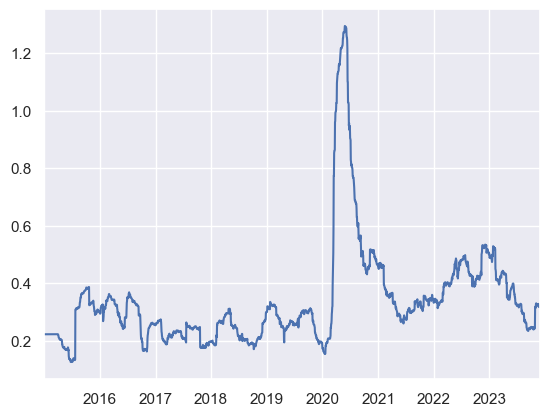

In [20]:
get_ivol(stock_px).plot()